## Destination classification

## 1. Importing module

In [407]:
import tensorflow as tf
import numpy as np

import matplotlib as plt

import json


# https://pypi.org/project/vietnam-provinces/

from vietnam_provinces.enums import ProvinceEnum, ProvinceDEnum, DistrictDEnum

## 2. Prepare data

In [408]:
PROVINCES_DICT = {}
i = 0
for member in ProvinceDEnum:
    lowercase = member.value.name.lower()
    PROVINCES_DICT[lowercase] = i
    i += 1
for member in DistrictDEnum:
    lowercase = member.value.name.lower()
    if lowercase.startswith("thành phố"):
        PROVINCES_DICT[lowercase] = i
        i += 1
# Invert the dictionary
PROVINCES_DICT = {value: key for key, value in PROVINCES_DICT.items()}


with open("../data/dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)


sentences = []
labels = []
format_data = []
for item in data:
    sentence = item["sentence"]
    label = item["label"]
    sentences.append(sentence)
    labels.append(label)
    label = PROVINCES_DICT[label]
    new_data = {"sentence": sentence, "label": label}
    format_data.append(new_data)

i = 0
for item in format_data:
    if i >= 17:
        print(i, item["sentence"], item["label"], sep="|")
    i += 1

17|anh thích hải sản ở Tỉnh Bình Dương, có quán nào ngon mà giới thiệu không?|tỉnh bình dương
18|Tại Phan Thiết, có nhiều sự kiện văn hóa độc đáo, ông muốn tham gia không?|thành phố phan thiết
19|Thành Phố Mỹ Tho dễ thương quá, bà nội thích thăm lại lần nữa.|thành phố mỹ tho
20|Lào Cai dễ thương quá, anh thích thăm lại lần nữa.|tỉnh lào cai
21|Muốn đi Sóc Trăng quá à|tỉnh sóc trăng
22|ông nội ở Quảng Trị, có điểm du lịch gì độc đáo không?|tỉnh quảng trị
23|Ở Quảng Bình có nhiều cửa hàng độc đáo, vợ đã mua đồ ở đó chưa?|tỉnh quảng bình
24|Buổi tối ở Tỉnh Quảng Ngãi thì nên đi đâu chơi?|tỉnh quảng ngãi
25|Cuối tháng, bà ngoài lên Thành Phố Rạch Giá thăm người thân.|thành phố rạch giá
26|bà nội thích hải sản ở Tỉnh Thái Nguyên, có quán nào ngon mà giới thiệu không?|tỉnh thái nguyên
27|Tỉnh Bà Rịa - Vũng Tàu có nhiều điểm ẩm thực ngon, ba biết chưa?|tỉnh bà rịa - vũng tàu
28|Thành Phố Lạng Sơn có nhiều địa điểm mua sắm, bà ngoài muốn ghé không?|thành phố lạng sơn
29|ông sắp đến Bắc Kạn, nơ

## 3. Define constant

In [409]:
vocab_size = 200
embedding_dim = 16
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 15000

## 4. Split training size and label

In [410]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print(training_labels)

[85, 7, 122, 58, 17, 124, 51, 138, 117, 60, 53, 58, 1, 3, 133, 40, 4, 46, 110, 129, 5, 60, 29, 28, 33, 138, 11, 48, 76, 3, 5, 56, 39, 106, 143, 4, 62, 14, 129, 106, 27, 25, 73, 145, 9, 74, 39, 108, 13, 59, 11, 20, 75, 108, 122, 109, 65, 138, 11, 11, 99, 7, 112, 3, 11, 127, 39, 110, 92, 25, 22, 128, 14, 99, 80, 121, 137, 64, 125, 34, 2, 51, 115, 140, 121, 101, 4, 40, 126, 17, 17, 140, 50, 19, 28, 43, 84, 133, 126, 84, 15, 139, 49, 106, 105, 103, 76, 20, 115, 30, 95, 1, 53, 109, 138, 11, 21, 21, 89, 92, 110, 13, 18, 100, 134, 54, 129, 41, 7, 123, 53, 117, 51, 108, 69, 109, 25, 140, 37, 26, 0, 4, 73, 60, 5, 2, 143, 13, 55, 48, 34, 59, 88, 27, 61, 102, 137, 81, 15, 133, 120, 79, 113, 21, 108, 45, 73, 84, 65, 130, 113, 11, 140, 17, 8, 81, 47, 50, 78, 50, 137, 105, 72, 61, 7, 41, 86, 76, 19, 119, 112, 2, 8, 8, 76, 29, 27, 9, 122, 37, 122, 40, 58, 117, 1, 41, 76, 5, 85, 143, 101, 130, 9, 54, 120, 5, 0, 112, 38, 71, 94, 121, 136, 130, 28, 119, 24, 118, 49, 127, 4, 122, 33, 61, 87, 135, 22, 6, 

## 5. Tokenization

In [411]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, oov_token=oov_tok
)
# Tokenize the text
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print(word_index)
# Turn the training text to sequence
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    training_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)

{'<OOV>': 1, 'ở': 2, 'có': 3, 'không': 4, 'thành': 5, 'phố': 6, 'nhiều': 7, 'điểm': 8, 'tỉnh': 9, 'thích': 10, 'muốn': 11, 'nào': 12, 'độc': 13, 'đáo': 14, 'lịch': 15, 'gì': 16, 'đi': 17, 'ngon': 18, 'nơi': 19, 'bà': 20, 'gia': 21, 'ông': 22, 'hội': 23, 'buổi': 24, 'tối': 25, 'thì': 26, 'nên': 27, 'chơi': 28, 'đây': 29, 'đồ': 30, 'du': 31, 'cảnh': 32, 'mua': 33, 'tham': 34, 'chưa': 35, 'thăm': 36, 'đến': 37, 'này': 38, 'lễ': 39, 'quá': 40, 'quán': 41, 'ghé': 42, 'địa': 43, 'nội': 44, 'anh': 45, 'bình': 46, 'hải': 47, 'hóa': 48, 'thơ': 49, 'yên': 50, 'đâu': 51, 'ninh': 52, 'giang': 53, 'dễ': 54, 'thương': 55, 'lại': 56, 'lần': 57, 'nữa': 58, 'thấy': 59, 'thời': 60, 'tiết': 61, 'se': 62, 'lạnh': 63, 'đúng': 64, 'cửa': 65, 'hàng': 66, 'đã': 67, 'đó': 68, 'hà': 69, 'tại': 70, 'sự': 71, 'kiện': 72, 'văn': 73, 'đang': 74, 'vui': 75, 'phong': 76, 'mộng': 77, 'ngắm': 78, 'sử': 79, 'hay': 80, 'mùa': 81, 'nhất': 82, 'sản': 83, 'mà': 84, 'giới': 85, 'thiệu': 86, 'sắp': 87, 'ăn': 88, 'để': 89, 'cả

In [412]:
# Need this block to get it to work with TensorFlow 2.x
# convert "list" (Nth dimesion arrat) to "NDArray" using numpy library

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## 6. Training the model

In [413]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
        tf.keras.layers.Dense(24, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
        tf.keras.layers.Dense(
            len(PROVINCES_DICT), activation=tf.keras.activations.softmax
        ),
    ]
)
# For multi category use sparse categorical is the best
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.002),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 100, 16)           3200      
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_62 (Dense)            (None, 24)                408       
                                                                 
 dropout_16 (Dropout)        (None, 24)                0         
                                                                 
 dense_63 (Dense)            (None, 146)               3650      
                                                     

In [414]:
num_epochs = 30
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
)

Epoch 1/30
469/469 [==============================] - 2s 4ms/step - loss: 4.9468 - accuracy: 0.0121 - val_loss: 4.8987 - val_accuracy: 0.0120
Epoch 2/30
469/469 [==============================] - 2s 3ms/step - loss: 4.6240 - accuracy: 0.0175 - val_loss: 4.3185 - val_accuracy: 0.0200
Epoch 3/30
469/469 [==============================] - 2s 3ms/step - loss: 4.1889 - accuracy: 0.0323 - val_loss: 3.9719 - val_accuracy: 0.0382
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 3.8734 - accuracy: 0.0624 - val_loss: 3.5505 - val_accuracy: 0.1378
Epoch 5/30
469/469 [==============================] - 2s 3ms/step - loss: 3.4657 - accuracy: 0.1169 - val_loss: 3.0243 - val_accuracy: 0.2472
Epoch 6/30
469/469 [==============================] - 2s 3ms/step - loss: 3.0623 - accuracy: 0.1803 - val_loss: 2.5517 - val_accuracy: 0.4296
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 2.7213 - accuracy: 0.2506 - val_loss: 2.1547 - val_accuracy: 0.5586
Epoch 

## 7. Create the graph for better understanding

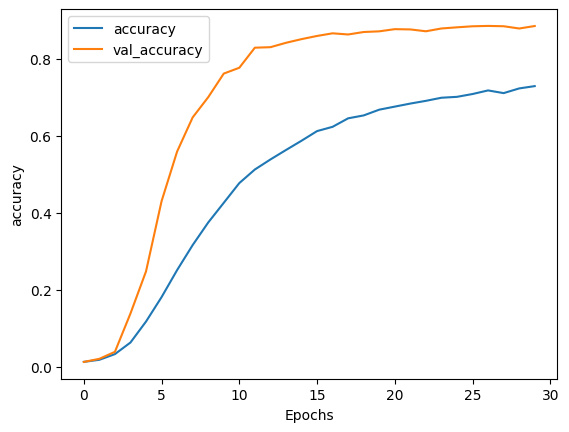

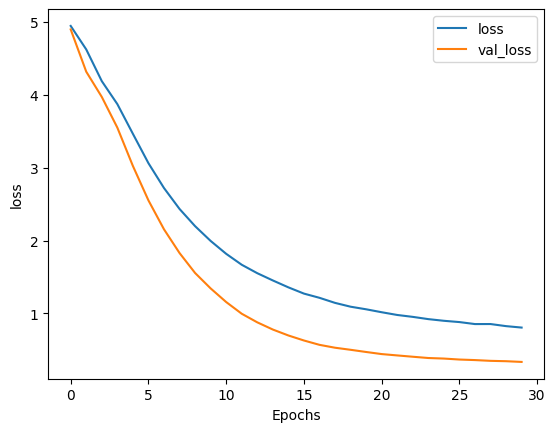

DECODE sentence
ông nội ở thành phố bắc ninh có nơi nào là địa điểm check in nổi tiếng không ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Original sentence
ông nội ở Thành Phố Bắc Ninh, có nơi nào là địa điểm check-in nổi tiếng không?
City:
85
[[-6.8205236e-03  1.6751770e-02 -1.0173680e-02 ... -2.3648584e-02
  -2.7204406e-02  1.7791307e-02]
 [ 2.8106050e+00 -1.3820328e+00 -1.5699132e-01 ...  3.1718330e+00
   3.3438969e+00 -2.6796143e+00]
 [ 4.1211225e-02  3.0764844e-02 -3.7662385e-03 ... -2.1832169e-03
   2.6900807e-02 -1.3405170e-01]
 ...
 [-3.5071537e+00  7.2688818e+00 -1.9629352e+00 ... -1.5632346e+00
  -1.2852550e+00  1.7817296e+00]
 [-8.7308580e-01  1.3286796e+00 -1.4325508e+00 ... -4.2871737e-01
  -1.3213878e+00  1.5835040e+00]
 [ 2.4788771e+00 -5.7842889e+00  1.9368292e+00 ...  5.7350926e+00
  -9.9250108e-01 -4.7634491e-01]]


In [415]:
import matplotlib.pyplot as plt


def plot_graphs(history, str):
    plt.plot(history.history[str])
    plt.plot(history.history["val_" + str])
    plt.xlabel("Epochs")
    plt.ylabel(str)
    plt.legend([str, "val_" + str])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# decode the word index back to original word
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_sentences(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])


print("DECODE sentence")
print(decode_sentences(training_padded[0]))
print("Original sentence")
print(training_sentences[0])
print("City:")
print(labels[0])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights)  # shape: (vocab_size, embedding_dim)

## 8. Saving the model

In [416]:
# Saving the whole model
# HDF5 format
model.save("nn.h5")

# Saving only weight
# model.save_weights("nn_weight.h5")

# Saving only the architecture
# json_str = model.to_json()
# with open("nn_model.json", "w") as f:
#     f.write(json_str)


d:\#Code\My Project\Test\JupiterNotebook\bus_ticket_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 9. Predict data using pre-trained model

1/1 [==============================] - 0s 66ms/step
thành phố buôn ma thuột 0.37985045
17
[ 49  74  79  80  82  91 105 107 108 109 113 116 119 120 129 138 142]


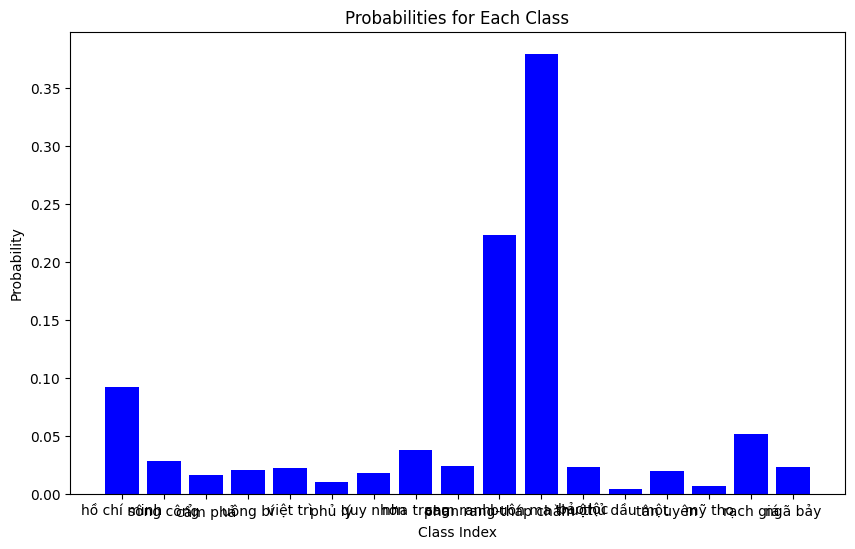

In [434]:
# Data to predict
sentences = [
    "Mai mình sẽ tới thành phố Đà Lạt",
]


def remove_location_prefix(input_string):
    prefixes = ["thành phố", "tỉnh"]
    for prefix in prefixes:
        if input_string.startswith(prefix):
            input_string = input_string.replace(prefix, "", 1).strip()
    return input_string


pretrain_model = tf.keras.models.load_model("nn.h5")

sequences = tokenizer.texts_to_sequences(sentences)
padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)
prediction = pretrain_model.predict(padded)
maxIndex = np.argmax(prediction[0])
max = np.max(prediction[0])
print(PROVINCES_DICT[maxIndex], max)


# Displaying graph
probability_array = np.array([prediction])

# Assuming threshold is 10%
threshold = 0.001
# Ensure that the probability array is 1D
probabilities = probability_array.ravel()

# Creating an array of indices for each probability
indices = np.arange(len(probabilities))
# Filter indices and probabilities
filtered_indices = indices[probabilities >= threshold]
filtered_probabilities = probabilities[probabilities >= threshold]


formatted_filtered_class = [
    remove_location_prefix(PROVINCES_DICT[index]) for index in filtered_indices
]
print(len(filtered_indices))
print(filtered_indices)
# Plotting the probabilities
plt.figure(figsize=(10, 6))
plt.bar(formatted_filtered_class, filtered_probabilities, color="blue")
plt.xlabel("Class Index")
plt.ylabel("Probability")
plt.title(sentences[0])
plt.show()